In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 33.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4c8bab1b08dc49a50766adc38f8c4939a574b5b65d2cee337d867539d80b2f6c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [1]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

import pandas as pd
import wget
import numpy as np
import json
import os
import pickle
import yaml
import shutil
from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf

import warnings; warnings.simplefilter('ignore')

from drive.MyDrive.mushroom_classification.new import FGVC_src
from drive.MyDrive.mushroom_classification.new.src import tfrecord_functions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
CFG = yaml.safe_load(open('drive/MyDrive/mushroom_classification/new/src/config.YAML', 'rb'))

# Download Data

In [4]:
train, val, test = FGVC_src.get_images()
train = pd.read_csv(CFG['path'] + 'dataframes/train.csv')
val = pd.read_csv(CFG['path'] + 'dataframes/val.csv')
test = pd.read_csv(CFG['path'] + 'dataframes/test.csv')
train = pd.concat([train], ignore_index=True)
val = pd.concat([val], ignore_index=True)
train['species_per_genus'] = train.groupby('category_id')['category_id'].transform('count')
val['species_per_genus'] = val.groupby('category_id')['category_id'].transform('count')

In [6]:
# !mkdir val
# img_list = !ls images
# FGVC_src.create_val_dir(train, val, img_list)

FileExistsError: ignored

In [6]:
train, val = FGVC_src.create_filepaths(train, val)

In [7]:
train['label'] = train['category_id']
val['label'] = val['category_id']

# Writing Records

In [11]:
print(val.shape[0], train.shape[0], test.shape[0])

4182 85578 9758


In [12]:
!du -hs test
!du -hs train

1.4G	test
14G	train


In [13]:
rootdir = 'content'
tfrecords_dir = 'tfrecords'

train_dir = 'train'
train_dir = os.path.join(rootdir, train_dir)

test_dir = 'test'
test_dir = os.path.join(rootdir, test_dir)

train_samples_per_record = 2048
train_num_records = train.shape[0] // train_samples_per_record

val_samples_per_record = 1024
val_num_records = val.shape[0] // val_samples_per_record

test_samples_per_record = 2048
test_num_records = test.shape[0] // test_samples_per_record

if train.shape[0] % train_samples_per_record:
    train_num_records += 1
if val.shape[0] % val_samples_per_record:
    val_num_records += 1
if test.shape[0] % test_samples_per_record:
    test_num_records += 1
if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)

In [93]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "category_id": int64_feature(example["label"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def create_test_example(image, path):
    feature = {
        'image': image_feature(image),
        'path': bytes_feature(path)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

def parse_tfrecord_tests(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

## Train

In [36]:
for record_num in range(train_num_records):
    samples = train.iloc[(record_num * train_samples_per_record) : ((record_num + 1) * train_samples_per_record)]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f'/train/{record_num}_FGVC_train_{len(samples)}.tfrec'
    ) as writer:

        for idx, row in samples.iterrows():           
            img_path = row['filepath']
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            # print(image)
            # image = tf.image.resize(image, [512, 512])
            # print(image)
            example = tfrecord_fucntions.create_example(image, img_path, row)
            # print(example)
            writer.write(example.SerializeToString())

tf.Tensor(
[[[67 59 46]
  [57 49 36]
  [52 44 33]
  ...
  [59 58 56]
  [54 50 49]
  [54 50 49]]

 [[61 53 42]
  [51 43 32]
  [48 40 29]
  ...
  [56 55 53]
  [52 48 47]
  [54 50 49]]

 [[58 51 41]
  [47 40 30]
  [45 38 28]
  ...
  [67 66 64]
  [61 60 58]
  [63 62 60]]

 ...

 [[61 66 59]
  [77 82 75]
  [76 79 70]
  ...
  [33 31 42]
  [31 29 40]
  [31 29 40]]

 [[55 58 51]
  [71 74 67]
  [69 72 63]
  ...
  [30 28 39]
  [30 28 39]
  [31 29 40]]

 [[31 34 27]
  [52 55 48]
  [57 60 51]
  ...
  [37 35 46]
  [41 39 50]
  [43 41 52]]], shape=(576, 1024, 3), dtype=uint8)
tf.Tensor(
[[[61.625   53.625   40.75   ]
  [51.34375 43.3125  32.375  ]
  [66.90625 57.90625 50.96875]
  ...
  [66.6875  65.6875  63.6875 ]
  [62.875   61.875   59.875  ]
  [53.9375  49.9375  48.9375 ]]

 [[55.34375 47.53125 36.71875]
  [48.53125 40.3125  30.5    ]
  [64.5625  55.9375  49.75   ]
  ...
  [72.125   71.125   69.125  ]
  [63.25    62.25    60.25   ]
  [54.6875  51.25    50.0625 ]]

 [[52.96875 46.4375  36.90625]
 

InvalidArgumentError: ignored

category_id: 672
path: b'train/16667_Macrotyphula_fistulosa/FS2016-9184347_HyuzqT14l.JPG'
Image shape: (768, 1024, 3)


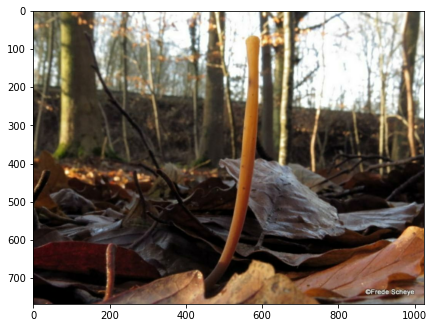

In [80]:
raw_dataset = tf.data.TFRecordDataset(f"tfrecords/train/1_FGVC_train_2048.tfrec")
parsed_dataset = raw_dataset.map(tfrecord_functions.parse_tfrecord_fn)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

## Validation

In [ ]:
for record_num in range(val_num_records):
    samples = val.iloc[(record_num * val_samples_per_record) : ((record_num + 1) * val_samples_per_record)]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f'/val/{record_num}_FGVC_val_{len(samples)}-original.tfrec'
    ) as writer:

        for idx, row in samples.iterrows():           
            img_path = row['filepath']
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            example = tfrecord_functions.create_example(image, img_path, row)
            #print(example)
            writer.write(example.SerializeToString())

category_id: 908
path: b'train/19517_Pucciniastrum_areolatum/EAT2009PIC42996062.JPG'
Image shape: (588, 784, 3)


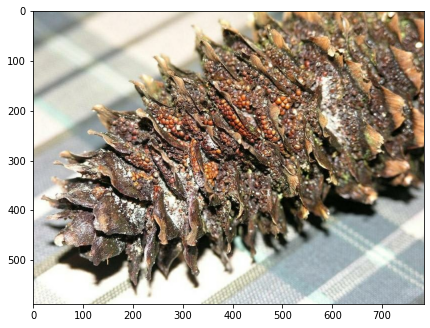

In [74]:
raw_dataset = tf.data.TFRecordDataset(f"tfrecords/val/1_FGVC_val_1024-original.tfrec")
parsed_dataset = raw_dataset.map(tfrecord_functions.parse_tfrecord_fn)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

## Test

In [94]:
for record_num in range(test_num_records):
    test_files = os.listdir('test')
    samples = test_files[(record_num * test_samples_per_record) : ((record_num + 1) * test_samples_per_record)]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f'/test/{record_num}_FGVC_test_{len(samples)}-original.tfrec'
    ) as writer:

        for sample in samples:           
            img_path = 'test/' + sample
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            example = tfrecord_functions.create_test_example(image, img_path)
            #print(example)
            writer.write(example.SerializeToString())

path: b'test/123238.jpg'
Image shape: (768, 1024, 3)


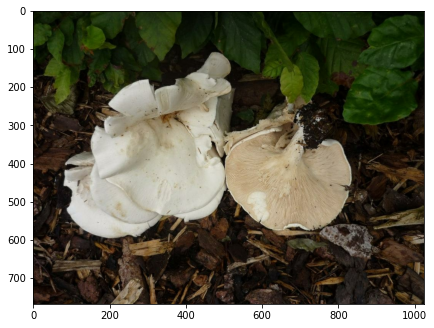

In [97]:
raw_dataset = tf.data.TFRecordDataset(f"tfrecords/test/1_FGVC_test_2048-original.tfrec")
parsed_dataset = raw_dataset.map(tfrecord_functions.parse_tfrecord_tests)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [98]:
!gsutil -m cp -r /content/tfrecords gs://mushy_class

Copying file:///content/tfrecords/train/26_FGVC_train_2048.tfrec [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///content/tfrecords/test/2_FGVC_test_2048-original.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/test/1_FGVC_test_2048-original.tfrec [Content-Type=application/octet